In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import numpy as np
import xgboost as xgb
import random
from scipy import stats
from sklearn import svm
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,TimeSeriesSplit

In [32]:
os.chdir('/Users/yuy/Documents/life/resume/Amazon/')
device_failure=pd.read_csv('device_failure.csv')

### parameter setting

In [33]:
rs=1234
random.seed(rs)
s_window=7 #short memory window
l_window=30 #long memory window
#these values above could be changed and different values could be tested

# I. Data Exploration

In [34]:
device_failure.date=pd.to_datetime(device_failure.date)

In [35]:
#starting with data head examination
device_failure.sort_values('date',inplace=True)
device_failure.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
779,2015-01-01,W1F0Y13C,0,234318640,0,0,0,4,185772,0,0,3
778,2015-01-01,W1F0XKWR,0,89660704,0,0,0,7,30,0,0,0
777,2015-01-01,W1F0X7QX,0,162013456,0,0,0,12,217686,0,0,0
776,2015-01-01,W1F0X7PR,0,13138392,0,0,0,9,191343,0,0,0


In [36]:
device_failure.tail()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
124464,2015-11-02,S1F0EGMT,0,159867281,0,0,13,11,347165,32,32,0
124463,2015-11-02,S1F0E9EP,0,205465736,0,0,12,11,353337,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0
124477,2015-11-02,W1F0FY92,0,128174672,0,1,6,15,356320,0,0,1
124493,2015-11-02,Z1F0QLC1,0,17572840,0,0,0,10,351431,0,0,0


In [37]:
#the time window for the data is 2015-01-01 to 2015-11-02

In [38]:
print (device_failure.shape)
print ('Number of days in sample is %d'%(device_failure.date.unique().shape[0]))
print ('Number of unique devices is %d'%(device_failure.device.unique().shape[0]))
#it seems that not all devices give reports every day. find out more of the device reporting patterns
freq=device_failure.device.value_counts()
print ('Number of times a device shows up in our sample (left is the appearence frequency, right is the number of devices)')
freq_counts=freq.value_counts(sort=False) 
print (freq_counts.head(),freq_counts.tail())
#some devices only show up 3 times in the sample, while others show up every day.

(124494, 12)
Number of days in sample is 304
Number of unique devices is 1168
Number of times a device shows up in our sample (left is the appearence frequency, right is the number of devices)
3      1
4      1
5    106
6    209
7     44
Name: device, dtype: int64 287     1
292    37
295    36
299     1
304    27
Name: device, dtype: int64


In [39]:
freq.tail()#spot check on infrequent devices

S1F0CTRL    5
Z1F0LKBP    5
W1F0KDDQ    5
S1F04KSC    4
W1F0WJFT    3
Name: device, dtype: int64

In [40]:
device_failure[device_failure.device=='W1F0WJFT'] 
#this device only shows up at the beginning of the sample period

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
725,2015-01-01,W1F0WJFT,0,193938760,0,0,0,9,217819,0,0,1
1888,2015-01-02,W1F0WJFT,0,22907208,0,0,0,9,217819,0,0,1
3051,2015-01-03,W1F0WJFT,0,142903640,0,0,0,9,217819,0,0,1


In [41]:
device_failure[device_failure.device=='S1F09MAK'] #so is this device

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
45,2015-01-01,S1F09MAK,0,9461552,7928,0,7,3,306534,0,0,4
1208,2015-01-02,S1F09MAK,0,31592888,7944,0,7,3,306534,0,0,4
2371,2015-01-03,S1F09MAK,0,52282144,8392,0,7,3,306534,0,0,4
3534,2015-01-04,S1F09MAK,0,74134944,8392,0,7,3,306534,0,0,4
4695,2015-01-05,S1F09MAK,0,97346208,8392,0,7,3,306534,0,0,4


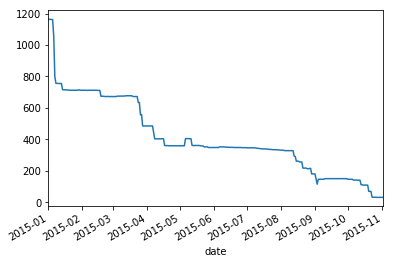

In [42]:
device_failure.groupby('date').device.count().plot() 
#looks like the number of devices in the sample keeps dropping over time. 
#However it's not necessarily due to device failure, since the last observation 
#of a device isn't always failure==1.
#one guess here is that a certain % of devices are taking out of the sample for 
#maintanence (not based on failure probability)
#in addition to those that failed and have to be taken out. 
#Given that 40~50% are taken out each time, the cost of maintanence
#is probably not very high and the cost of failure might be high 
#(that's why so many are taken out even though the natural
#daily failure rate isn't high as shown by plots below).

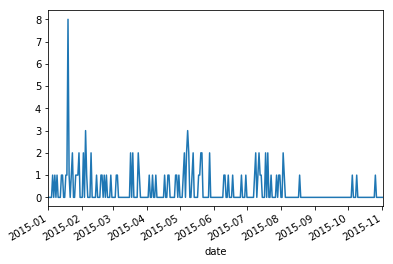

In [43]:
#check daily failure numbers
device_failure.groupby('date').failure.sum().plot() 
#daily failure number is mostly 0-2, with some outliers  being 3-8.

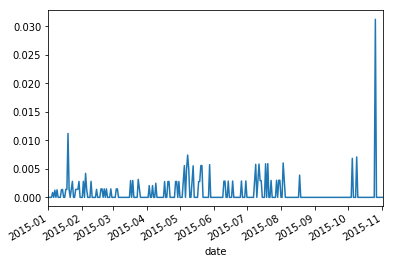

In [44]:
#check daily failure rate
rate=device_failure.groupby('date').failure.sum()
    /device_failure.groupby('date').failure.count()
rate.plot()

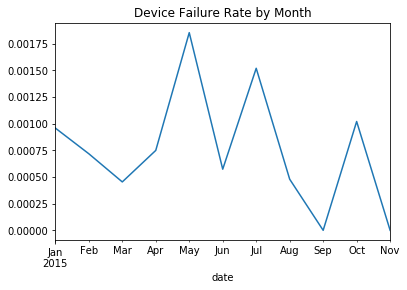

In [45]:
#aggregate the failure rate to monthly level
check=device_failure.copy()
check.set_index(['device','date'],inplace=True)
check.sort_index(inplace=True)
monthly_failure=check.resample('M',label='right',
                               convention='end',level='date').failure.sum()
monthly_base=check.resample('M',label='right',
                            convention='end',level='date').failure.count()
monthly_rate=monthly_failure/monthly_base
monthly_rate.plot()
plt.title('Device Failure Rate by Month')
plt.show()
#maybe the failure rate decreases slightly over time on average, 
#but the month to month variation is very large. 

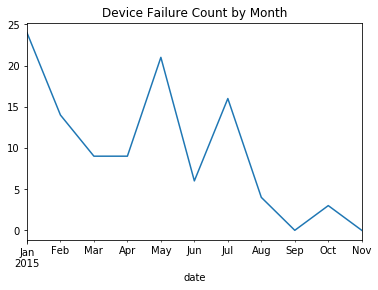

In [46]:
monthly_failure.plot() 
plt.title('Device Failure Count by Month')
#the number of monthly failures generally decreases over time, 
#because the overall device set is shrinking

In [47]:
#failure frequency by device
failed_vs_not=device_failure.groupby('device').failure.sum().value_counts()
#each device has at most one failure.
print (failed_vs_not)
#those with and without failure number 1:10

#list the devices with failures
failed=device_failure[device_failure['failure']==1].device
failed.reset_index(drop=True,inplace=True)
device_failure.loc[device_failure['device']==failed[3],['date','failure']] 
#after checking a few devices, it's clear that once a device fails, 
#it drops out of the sample. 
#Of course many other devices that never fails also drops out of the sample. 
#This illustrate that the problem is a time-series one, in the sense that 
#device failure predictions are made sequentially over time. 
#And as soon as a device fails, it will no longer be predicted on. 

0    1062
1     106
Name: failure, dtype: int64


,date,failure
824,2015-01-01,0
1987,2015-01-02,0
3150,2015-01-03,0
4312,2015-01-04,0
5473,2015-01-05,0
6575,2015-01-06,0
7425,2015-01-07,0
8181,2015-01-08,0
8937,2015-01-09,0
9692,2015-01-10,0


### Explore attributes for failed and not failed devices

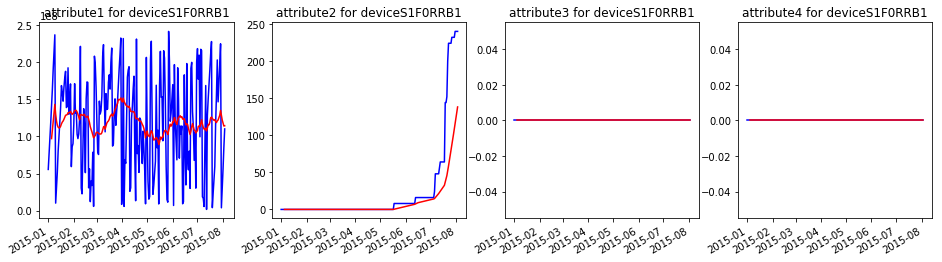

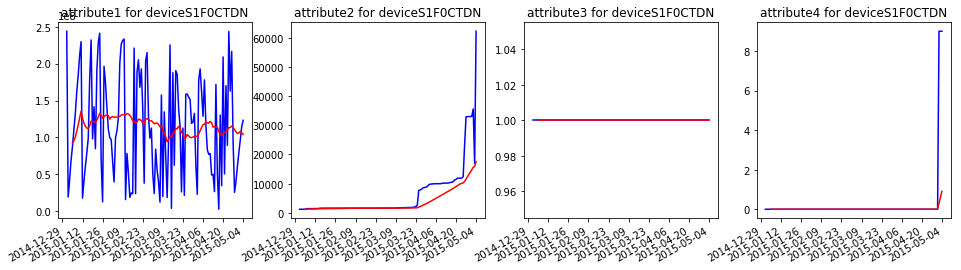

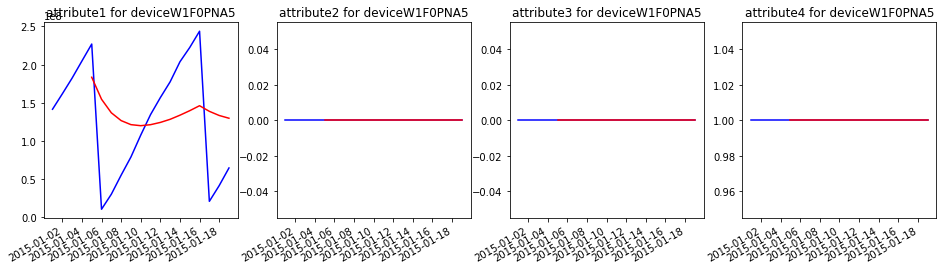

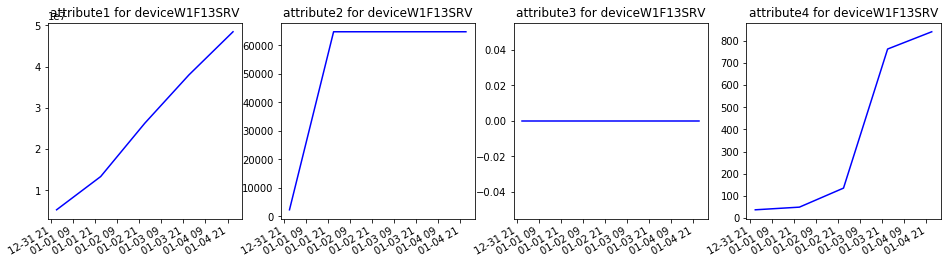

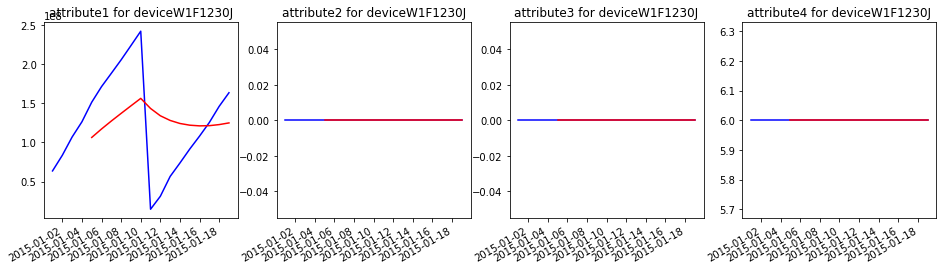

In [48]:
#first, for failed sample, let's see how attributes 1~5 value might change 
#as it gets closer to failure date
failed_sample=random.sample(failed.tolist(),5)
for i in range(5):
    fig,axes =plt.subplots(ncols=4,figsize=(16,4))
    fig.autofmt_xdate()
    for j in range(1,5):
    
        value=device_failure.loc[device_failure['device']==failed_sample[i],
                                 ['date','attribute'+str(j)]]
        rolling_mean=value['attribute'+str(j)].rolling(window=l_window, min_periods=5).mean()
        
        ax=axes[j-1]
        ax.plot(value['date'],value['attribute'+str(j)],'b')
        ax.plot(value['date'],rolling_mean,'r')
        ax.set_title('attribute'+str(j)+' for device'+failed[i])
        
    plt.show()


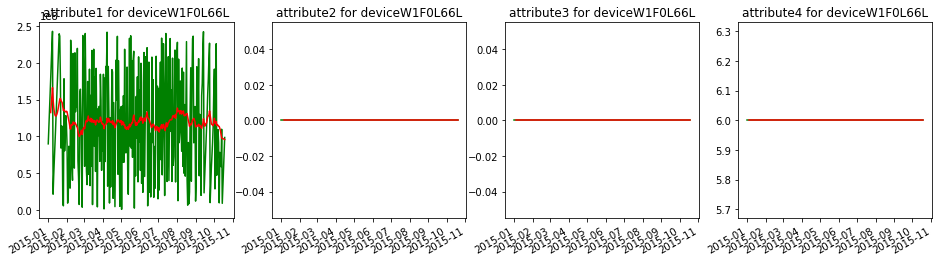

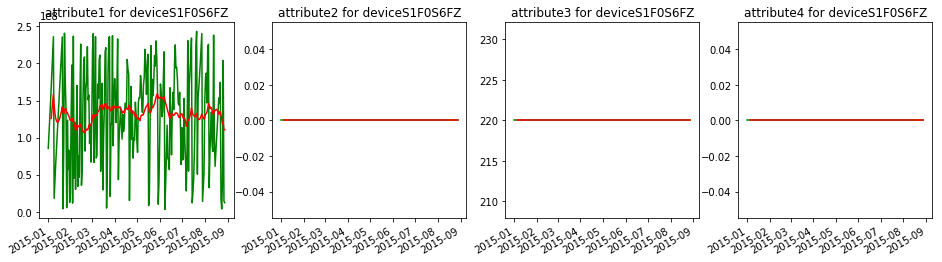

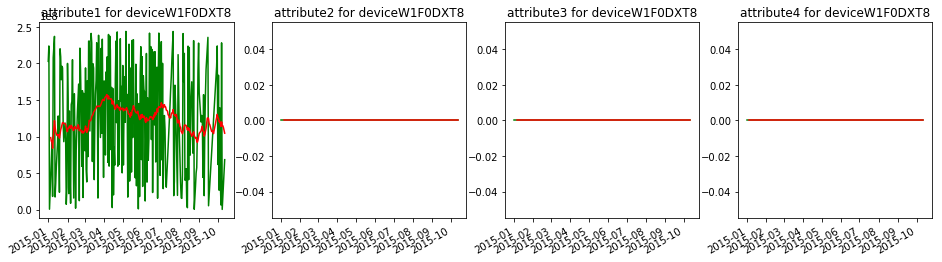

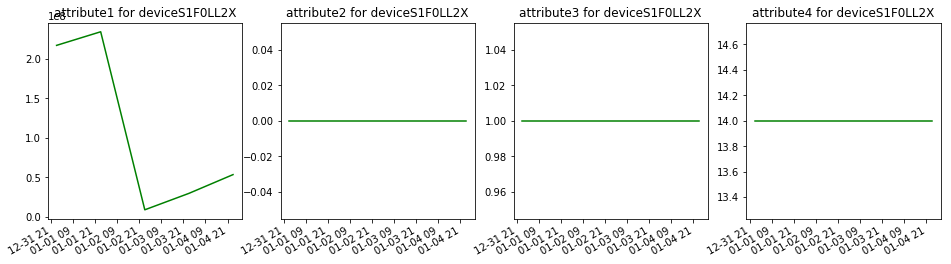

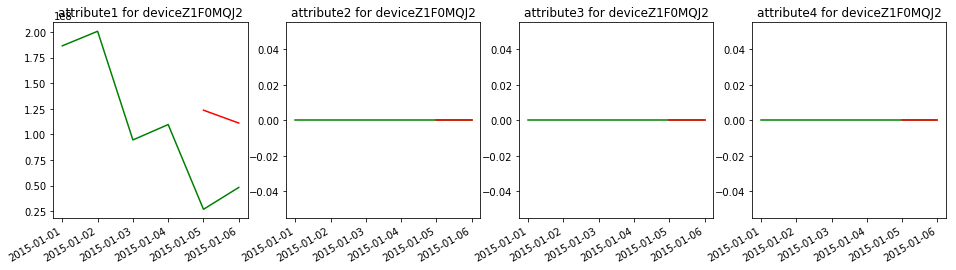

In [49]:
#contrast with the attributes 1~5 on not-failed sample (randomly drawn 100)
device=device_failure['device'].unique()
regular=set(device).difference(failed)
len(regular)
regular_sample=random.sample(regular,100)

for i in range(5):
    fig,axes =plt.subplots(ncols=4,figsize=(16,4))
    fig.autofmt_xdate()
    for j in range(1,5):
    
        value=device_failure.loc[device_failure['device']==regular_sample[i],
                                 ['date','attribute'+str(j)]]
        rolling_mean=value['attribute'+str(j)].rolling(window=l_window, min_periods=5).mean()
        
        ax=axes[j-1]
        ax.plot(value['date'],value['attribute'+str(j)],'g')
        ax.plot(value['date'],rolling_mean,'r')
        ax.set_title('attribute'+str(j)+' for device'+regular_sample[i])
        
    plt.show()


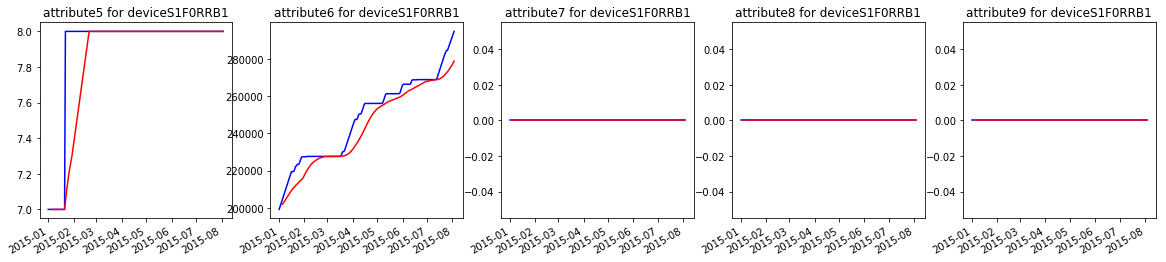

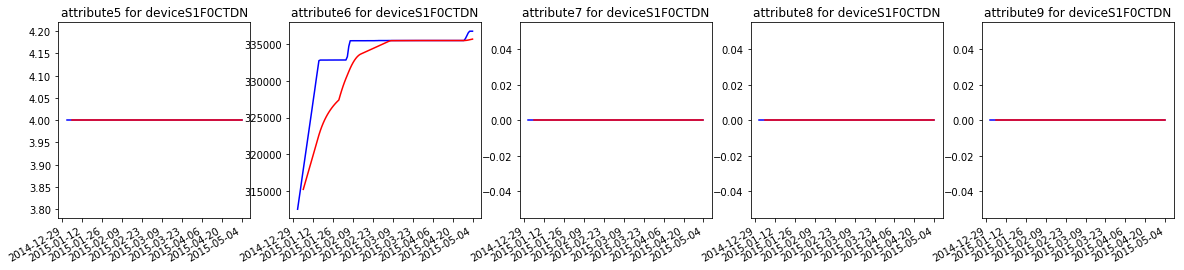

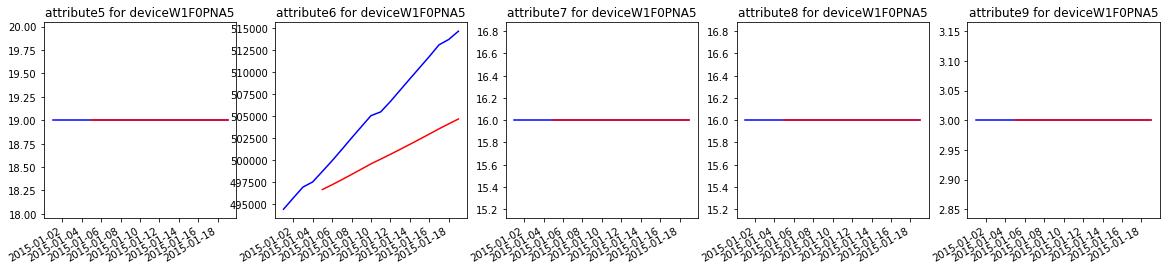

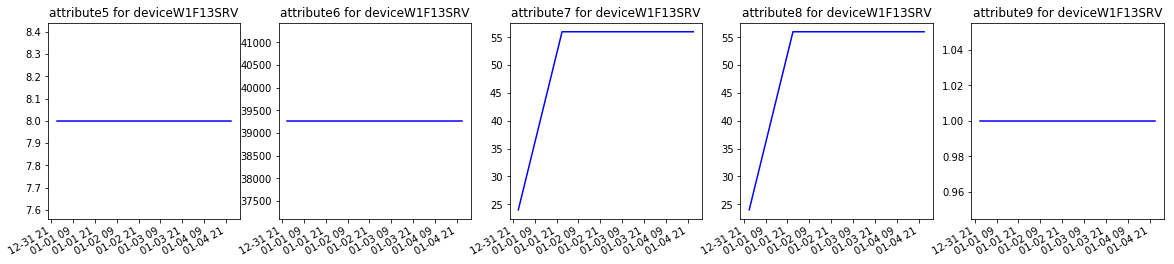

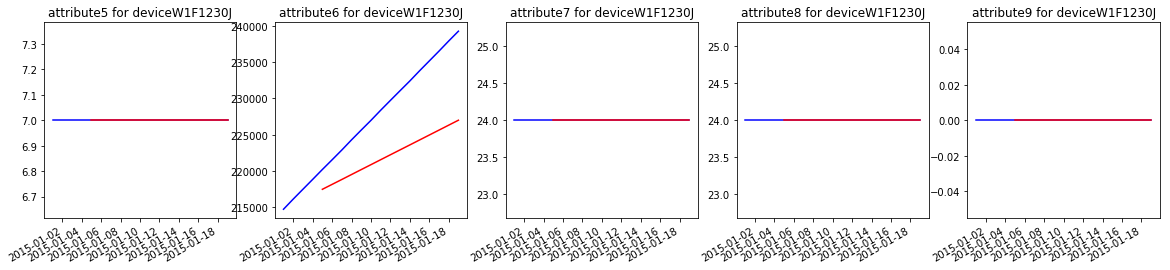

In [50]:
#now check attributes 5~9, failed sample
for i in range(5):
    fig,axes =plt.subplots(ncols=5,figsize=(20,4))
    fig.autofmt_xdate()
    for j in range(1,6):
    
        value=device_failure.loc[device_failure['device']==failed_sample[i],
                                 ['date','attribute'+str(4+j)]]
        rolling_mean=value['attribute'+str(4+j)].rolling(window=l_window, min_periods=5).mean()
        
        ax=axes[j-1]
        ax.plot(value['date'],value['attribute'+str(4+j)],'b')
        ax.plot(value['date'],rolling_mean,'r')
        ax.set_title('attribute'+str(4+j)+' for device'+failed[i])
        
    plt.show()

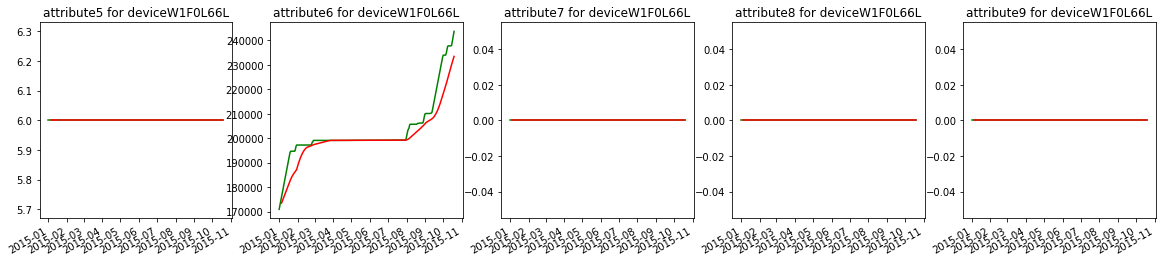

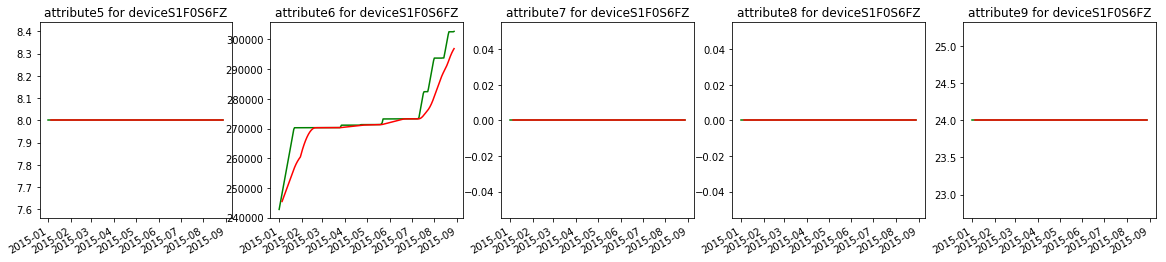

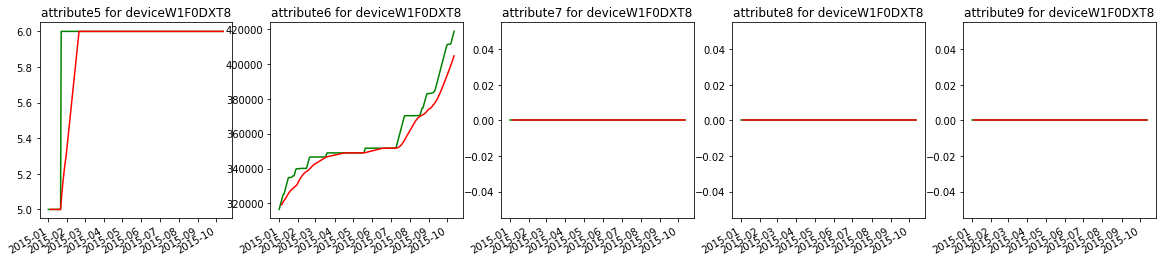

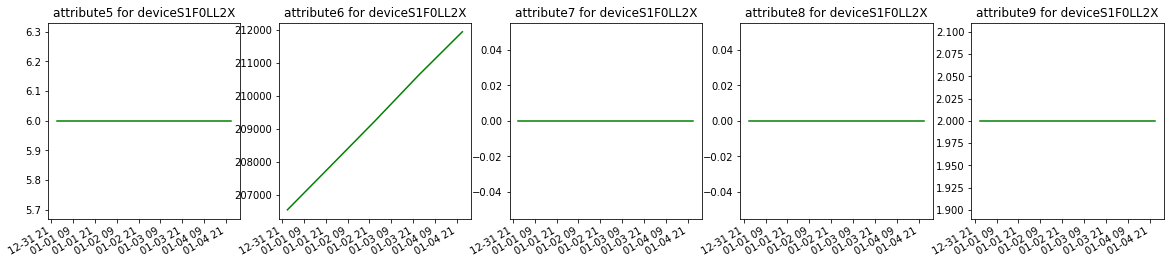

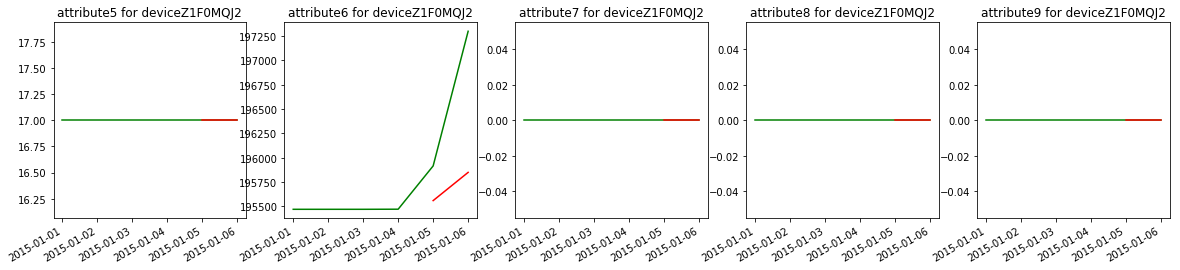

In [51]:
#not-failed sample (100 randomly drawn sample)
for i in range(5):
    fig,axes =plt.subplots(ncols=5,figsize=(20,4))
    fig.autofmt_xdate()
    for j in range(1,6):
    
        value=device_failure.loc[device_failure['device']==regular_sample[i],
                                 ['date','attribute'+str(4+j)]]
        rolling_mean=value['attribute'+str(4+j)].rolling(window=l_window, min_periods=5).mean()
        
        ax=axes[j-1]
        ax.plot(value['date'],value['attribute'+str(4+j)],'g')
        ax.plot(value['date'],rolling_mean,'r')
        ax.set_title('attribute'+str(4+j)+' for device'+regular_sample[i])
        
    plt.show()


From the plots above, we can see that in failure cases, attribute 2, 4, 7, 8 often have increases right before failure
compared to the normal set. While the other attributes have no clear differences from a casual examination. Attribute 6 has increase patterns for both failure and normal cases. We probably need to calculate the rate of change rather than the value itself. 

# II.Feature engineering

### 2.1 Create short and long term rolling mean and rolling std for some attributes

In [69]:
for i in range(1,10):
    device_failure['attribute'+str(i)+'_s_rolling_mean']=\
        device_failure['attribute'+str(i)].rolling(window=s_window,min_periods=5,center=False).mean()
    device_failure['attribute'+str(i)+'_l_rolling_mean']=\
        device_failure['attribute'+str(i)].rolling(window=l_window, min_periods=15).mean()

    if (i in (1,6)):
        device_failure['attribute'+str(i)+'_s_rolling_std']=\
            device_failure['attribute'+str(i)].rolling(window=s_window, min_periods=5).std()
        device_failure['attribute'+str(i)+'_l_rolling_std']=\
            device_failure['attribute'+str(i)].rolling(window=l_window, min_periods=15).std()

#print(device_failure) #check variable creation results

### 2.2 create changes from the initial values

In [53]:
temp=device_failure.copy()
temp['initial_date']=temp.groupby('device')['date'].transform('min')
first_record=temp[temp['date']==temp['initial_date']]

for i in range(1,10):
    first_record=first_record.rename(columns={'attribute'+str(i):'initial_attribute'+str(i)})

first_record.drop(['failure','date','initial_date',
                   'attribute1_s_rolling_mean','attribute2_s_rolling_mean',
                   'attribute3_s_rolling_mean','attribute4_s_rolling_mean',
                   'attribute5_s_rolling_mean','attribute6_s_rolling_mean',
                   'attribute7_s_rolling_mean','attribute8_s_rolling_mean',
                   'attribute9_s_rolling_mean',
                   'attribute1_s_rolling_std','attribute6_s_rolling_std',
                   'attribute1_l_rolling_mean','attribute2_l_rolling_mean',
                   'attribute3_l_rolling_mean','attribute4_l_rolling_mean',
                   'attribute5_l_rolling_mean','attribute6_l_rolling_mean',
                   'attribute7_l_rolling_mean','attribute8_l_rolling_mean',
                   'attribute9_l_rolling_mean',
                   'attribute1_l_rolling_std','attribute6_l_rolling_std'],
                  axis=1,inplace=True)

diff=pd.merge(device_failure,first_record,how='left',on='device')    
for i in range(1,10):
    diff['attribute'+str(i)+'_diff']=diff['attribute'+str(i)]-diff['initial_attribute'+str(i)]

diff.drop(['initial_attribute1','initial_attribute2',
                   'initial_attribute3','initial_attribute4','initial_attribute5',
                   'initial_attribute6','initial_attribute7','initial_attribute8',
                   'initial_attribute9'],axis=1,inplace=True)

### 2.3 single period change of attributes 

In [54]:
diff.set_index(['device','date'],inplace=True)
diff.sort_index(inplace=True)
shift=diff.shift(1,axis=0) #move the previous period x to the next period, 
#since we can only use last period values for prediction

for i in range(1,10):
    shift=shift.rename(columns={'attribute'+str(i):'lag_attribute'+str(i)})
    
shift.drop(['failure','attribute1_s_rolling_mean','attribute2_s_rolling_mean',
                   'attribute3_s_rolling_mean','attribute4_s_rolling_mean',
                    'attribute5_s_rolling_mean','attribute6_s_rolling_mean',
                    'attribute7_s_rolling_mean','attribute8_s_rolling_mean',
                   'attribute9_s_rolling_mean','attribute1_s_rolling_std',
                    'attribute6_s_rolling_std','attribute1_l_rolling_mean',
                    'attribute2_l_rolling_mean','attribute3_l_rolling_mean',
                    'attribute4_l_rolling_mean','attribute5_l_rolling_mean',
                   'attribute6_l_rolling_mean','attribute7_l_rolling_mean',
                    'attribute8_l_rolling_mean','attribute9_l_rolling_mean',
                   'attribute1_l_rolling_std','attribute6_l_rolling_std',
                   'attribute1_diff','attribute2_diff','attribute3_diff',
                    'attribute4_diff','attribute5_diff','attribute6_diff',
                    'attribute7_diff','attribute8_diff',
                   'attribute9_diff'],axis=1,inplace=True)

diff2=pd.merge(diff,shift,how='left',right_index=True,left_index=True)
for i in range(1,10):
    diff2['attribute'+str(i)+'_change']=diff2['attribute'+str(i)]
    -diff2['lag_attribute'+str(i)]


### 2.4 Shift next period failure up for prediction

In [55]:

results1=diff2.shift(-1,axis=0)
results1=results1['failure']
results_1=results1.to_frame(name='failure_next_period')

final_modeling_set=pd.merge(diff2,results_1,how='left',
                            right_index=True,left_index=True)
final_modeling_set.drop(['failure'],axis=1,inplace=True)
final_modeling_set.rename(columns={'failure_next_period':'y'},inplace=True)
final_modeling_set.reset_index(inplace=True)

## III. Model Fitting

### 3.1 creating training, validation and testing sample

In [56]:
#According to the number of failures per month, I use first 6 months 
#for training and validation, and the last 5 months for testing

train_val_sample=final_modeling_set[final_modeling_set.date<'2015-07-01']
train_indices=train_val_sample[train_val_sample.date<'2015-02-01'].index
testing_sample=final_modeling_set[final_modeling_set.date>='2015-07-01']
removal_list=['lag_attribute1','lag_attribute2','lag_attribute3','lag_attribute4',
              'lag_attribute5','lag_attribute6','lag_attribute7','lag_attribute8',
              'lag_attribute9']

train_val_sample.dropna(inplace=True)
train_val_sample.reset_index(drop=True,inplace=True)
testing_sample.dropna(inplace=True)
X_train=train_val_sample.drop(['y','date','device']+removal_list,1)
y_train=train_val_sample['y'].astype(int)
X_test=testing_sample.drop(['y','date','device']+removal_list,1)
y_test=testing_sample['y'].astype(int)

y_train.value_counts()

/Users/yuy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/yuy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


0    98078
1       83
Name: y, dtype: int64

In [57]:
#For train set, I create time series rolling forward 3 training 
#and 3 validation samples. 
#training sample are incrementally longer, and validation sample 
#is moved forward each time. 
tscv=TimeSeriesSplit(n_splits=3)
print(tscv)

for train,test in tscv.split(X_train):
    print('%s %s' %(train,test))

TimeSeriesSplit(max_train_size=None, n_splits=3)
[    0     1     2 ..., 24538 24539 24540] [24541 24542 24543 ..., 49078 49079 49080]
[    0     1     2 ..., 49078 49079 49080] [49081 49082 49083 ..., 73618 73619 73620]
[    0     1     2 ..., 73618 73619 73620] [73621 73622 73623 ..., 98158 98159 98160]


### 3.2 Cross validation and hyper-parameter search using Xgboost

In [58]:
print('running cross validation')

clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist_xgb = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 6,  9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
              }
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist_xgb, 
                         n_iter = 25, scoring = 'roc_auc', error_score = 0, 
                         cv=tscv, verbose = 0, n_jobs = -1,random_state=rs,
                         refit=True)
clf.fit(X_train,y_train)

#examine results
clf.cv_results_

print(clf.best_estimator_)

print(clf.best_score_)

best_param=clf.best_params_

preds_prob=clf.predict_proba(X_test)
#find the optimum hyper-parameters, apply them to the overall model training

preds_train_prob = clf.predict_proba(X_train)
preds_train = preds_train_prob[:,1]
print('Roc-auc for train sample is %.2f' %(roc_auc_score(y_train,preds_train)))

preds=preds_prob[:,1]
print('Roc-auc for test sample is %.2f' %(roc_auc_score(y_test,preds)))

running cross validation
XGBClassifier(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.50523443224391607, gamma=0,
       learning_rate=0.015008039720338307, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=292, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.67509616377213111)
0.850424426767
Roc-auc for train sample is 0.92
Roc-auc for test sample is 0.87


## IV. Model Performance Check on Test Sample 

### 4.1 Compute ROC curve and area under the curve

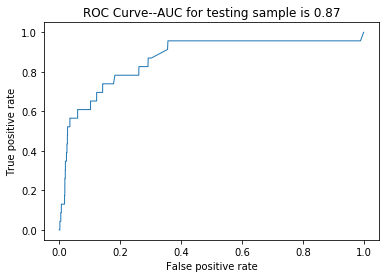

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1,
             label='ROC (AUC = %0.2f)' % (roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve--AUC for testing sample is %.2f' % 
          (roc_auc_score(y_test,preds)))
plt.show()

In [60]:
#calculate various other information on resulting predictions
roc_df=pd.DataFrame({'fpr':fpr,'tpr':tpr,'thresholds':thresholds})
roc_df['error_rate_for_positives']=roc_df.fpr
roc_df['error_rate_for_negatives']=0
roc_df['tp']=0
roc_df['tn']=0
roc_df['fp']=0
roc_df['fn']=0
roc_df['tp_device']=0
roc_df['tn_device']=0
roc_df['fp_device']=0
roc_df['fp_device']=0
roc_df['device_error_rate_for_positives']=0
roc_df['device_error_rate_for_negatives']=0

temp=testing_sample.copy()


for n in range(roc_df.shape[0]):
    i=roc_df.loc[n,'thresholds']
    preds_01 = preds >=i#/10.0
    preds_01=preds_01 *1
    cnf_matrix = confusion_matrix(y_test, preds_01)#.ravel()
    tn,fp,fn,tp = cnf_matrix.ravel()
    roc_df.loc[n,'tp']=tp
    roc_df.loc[n,'fp']=fp
    roc_df.loc[n,'tn']=tn
    roc_df.loc[n,'fn']=fn
    roc_df.loc[n,'error_rate_for_positives'] = fp/(fp+tn)
    roc_df.loc[n,'error_rate_for_negatives'] = fn/(fn+tp)
    
    temp.loc[:,'pred']=preds_01
    accuracy=temp.groupby('device')[['y','pred']].sum()
    accuracy.loc[:,'predicted']=accuracy.pred>0
    a=pd.crosstab(accuracy.y,accuracy.predicted)
    if a.shape[1]==1:
        a.loc[:,'True']=0
    tn_device,fp_device,fn_device,tp_device=a.values.ravel()
    roc_df.loc[n,'tp_device']=tp_device
    roc_df.loc[n,'fp_device']=fp_device
    roc_df.loc[n,'tn_device']=tn_device
    roc_df.loc[n,'fn_device']=fn_device
    roc_df['device_error_rate_for_positives']=
        fp_device/(tn_device+fp_device)
    roc_df['device_error_rate_for_negatives']=
        fn_device/(fn_device+tp_device)


### 4.2 plot the error rate tradeoff between the two classes. 

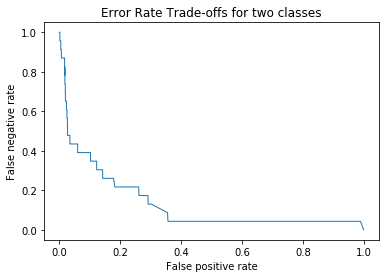

In [61]:
roc_df.sort_values('error_rate_for_positives',inplace=True)
plt.plot(roc_df.error_rate_for_positives, 
         roc_df.error_rate_for_negatives, lw=1, alpha=1,
         label='Error Rate Trade-offs for two classes')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.title('Error Rate Trade-offs for two classes' )
plt.show()

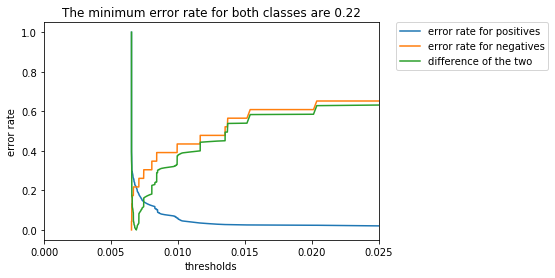

In [62]:
roc_df.diff=np.abs(roc_df.error_rate_for_negatives 
                   - roc_df.error_rate_for_positives)
minimum_error_rate=roc_df.loc[roc_df.diff==min(roc_df.diff),
                              'error_rate_for_negatives']

plt.plot(roc_df.thresholds,roc_df.error_rate_for_positives,
         label='error rate for positives')
plt.plot(roc_df.thresholds,roc_df.error_rate_for_negatives,
         label='error rate for negatives')
plt.plot(roc_df.thresholds,roc_df.diff,label='difference of the two')
plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.xlim([0,0.025])
plt.xlabel('thresholds')
plt.ylabel('error rate')
plt.title('The minimum error rate for both classes are %.2f' % 
          (minimum_error_rate))
plt.show()

In [63]:
#suppose that the cost of checking 100 good devices is equal to 
#the cost of missing one failing device
roc_df.trade_off=roc_df.fp-100*roc_df.tp
fp_cross=0
for i in range(len(roc_df.trade_off)-4,-1,-1):
    current=roc_df.trade_off[i]
    next_one = roc_df.trade_off[i+1]
    next_two = roc_df.trade_off[i+2]
    next_three = roc_df.trade_off[i+3]
    if (current<=0 and next_one >0 and next_two>0 and next_three >0): 
        fp_cross=roc_df.fp[i]
        print('fp_cross is',fp_cross)
        break

fp_cross is 1281


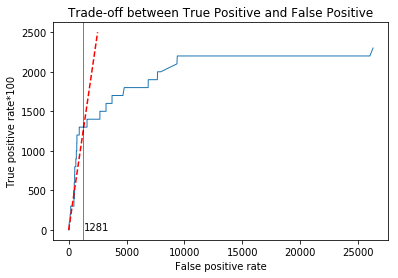

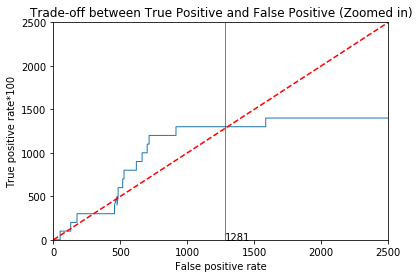

In [64]:
#the optimal threshold for failure prediction is to refer the top 
#1000+ for checking. It will capture about 14 failures and causes ~ 1000 wrong checks. 
plt.plot(roc_df.fp, roc_df.tp*100, lw=1, alpha=1)
plt.plot([0,2500],[0,2500],ls="--", c="red")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate*100')
plt.axvline(x=fp_cross,color='k',linewidth=0.5)
plt.text(fp_cross,0,'%d'%(fp_cross),rotation=0)
plt.title('Trade-off between True Positive and False Positive')
plt.show()    

plt.plot(roc_df.fp, roc_df.tp*100, lw=1, alpha=1)
plt.plot([0,2500],[0,2500],ls="--", c="red")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate*100')
plt.axvline(x=fp_cross,color='k',linewidth=0.5)
plt.text(fp_cross,0,'%d'%(fp_cross),rotation=0)
plt.title('Trade-off between True Positive and False Positive (Zoomed in)')
plt.xlim([0,2500])
plt.ylim([0,2500])
plt.show()


### 4.3 lift curve

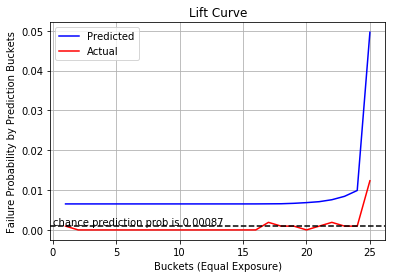

In [65]:
def lift(sortby, pred, actual, weight=None, savePath="e:\\mydata\\",
         n=10, plot=True, std=None, title="Gini", show=True):
    """
    sort, pred, actual, weight can be a 1-d numpy array or a single column of a pandas dataframe
    sortby = sort by variable
    pred = predicted values
    actual = actual values
    weight = weights (leave blank if NA)
    n = number of buckets
    plot = True if plot the resulting lift chart
    std = if not None, shows the error bar for each bucket
    """
    if weight is None:
        weight = np.ones_like(pred)

    def weighted_std(values, weight):
        """
        weighted std of an array
        this is slightly biased but shouldn't matter for big n
        """
        m = np.average(values, weights=weight)
        return np.sqrt(np.average((values-m)**2, weights=weight))

    r = np.vstack((sortby, pred, actual, weight)).T
    r = r[sortby.argsort()].T
    cumm_w = np.cumsum(r[3])
    cumm_y = np.cumsum(r[2]*r[3])
    total_w = np.sum(weight)
    gini = 1-2*(np.sum(cumm_y*r[3])/(np.sum(r[2]*r[3])*total_w))
    idx = np.clip(np.round(cumm_w*n/total_w + 0.5), 1, n) - 1
    lift_chart = np.zeros((n,7))
    for i in range(n):
        lift_chart[i][0] = np.sum(r[3][idx==i]) #num observations in each bucket
        lift_chart[i][1] = np.sum(r[1][idx==i]*r[3][idx==i])/lift_chart[i][0] #mean prediction
        lift_chart[i][2] = np.sum(r[2][idx==i]*r[3][idx==i])/lift_chart[i][0] #mean actual
        lift_chart[i][3] = weighted_std(r[1][idx==i],r[3][idx==i]) #weighted std
        lift_chart[i][4] = np.average(r[0][idx==i],weights=r[3][idx==i])#mean sortby variable
        lift_chart[i][5] = np.min(r[0][idx==i]) #min sortby variable
        lift_chart[i][6] = np.max(r[0][idx==i])#max sortby variable
    if plot==True:
        fig, ax = plt.subplots( nrows=1, ncols=1 )
        x = range(1,n+1)
        ax.plot(x, lift_chart[:,1], "b", label="Predicted")
        ax.plot(x,  lift_chart[:,2], "r", label="Actual")
        ax.grid(True)
        ax.set_xlabel("Buckets (Equal Exposure)")
        ax.set_ylabel("Failure Probability by Prediction Buckets")
        ax.axhline(y=actual.mean(),c='black',linestyle='--')
        ax.text(0,actual.mean()*1.5,'chance prediction prob is %.5f'%(actual.mean()),rotation=0)
        ax.legend(loc=2)
        if std is not None:
            ax.fill_between(x, lift_chart[:,1]+std*lift_chart[:,3],
                            lift_chart[:,1]-std*lift_chart[:,3],
                            color="b", alpha=0.1)
        #ax.set_title(title + "\n Gini: " + format(gini, ".4f"))
        ax.set_title('Lift Curve')
        fig.savefig(savePath + title + " Lift Chart.png")
        if(show==True):
            plt.show()
        plt.close(fig)
    #return gini, lift_chart

lift(preds,preds,y_test,n=25)

The probability level prediction is too high, possibly because as time passes and more devices drops out of 
the sample, the failure probability on remaining devices decreases. however the rank ordering of the failure prob among remaining devices is still much higher than random chance in the top quantiles. 

### 4.4 plot confusion matrix

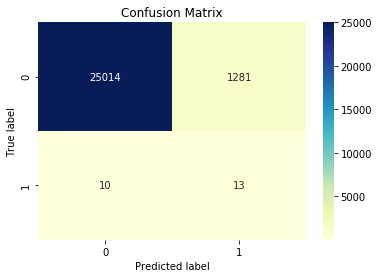

In [66]:
th_cross=roc_df.loc[roc_df.fp==fp_cross,'thresholds'].values[0]
preds_01 = preds >=th_cross
preds_01=preds_01 *1
cnf_matrix = confusion_matrix(y_test, preds_01)#.ravel()

ax=sns.heatmap(cnf_matrix,annot=True,fmt='d',cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
#by adopting the 100 false positive to one true positive cost calculation, 
#by referring the top 1000+ model predictions, we 
#capture more than half true failure incidences.

In [67]:
#additional check at device level

analysis=testing_sample.copy()
analysis.loc[:,'pred']=preds_01
accuracy=analysis.groupby('device')[['y','pred']].sum()
accuracy.loc[:,'predicted']=accuracy.pred>0
pd.crosstab(accuracy.y,accuracy.predicted)#.ravel()

predicted,False,True
y,,
0.0,276,50
1.0,8,15


***Comments***: 
There are other things I would like to try if I had more time. 

### 1. Further enhancing model performance
  * Fitting SVC, Random Forest, Logistic Regression models 
  * Fitting a Long Short Term Memory (LSTM) Neural Network model
  * Defining the problem as regression problem and run a survival models with censoring
  * Test different length of short term and long term rolling moving average and standard deviation statistics
  
### 2. Gather more business information to make the solution more realistic
  * Currently I assume that the cost of checking a suspected device is 0.01 of a missed failed device. In reality the ratio might be different, and we will have different model cutoff points for "failure" prediction
  * I assume that **one day ahead** prediction of failure is enough. In practice maybe longer than 1 day is required to perform mantainence and replace the device. In that case the model needs to be adjusted to use only n-day ahead info. 
  * Similarly, I am currently using data at the beginning of the dataset and up to 1 month history. Maybe different amount of **tracking window** is available in practice. In that case the feature construction will be adjusted
  * Because the attributes names and the business context is not given in further detail, I didn't attempt to explain the model. The only criteria i use now is predictive accuracy and lift. If business explanations of the model is important, I can further create variable importance list and partial dependence plot on the top variables. 

### 3. Putting the scoring into live production and potentially dynamically update the model as well
  * Currently the model is trained on data between 1-1-2015 and 6-30-2015. A scoring logic is applied on data between 7-1-2015 and 11-2-2015. If the model is put into production, I will modify the code to ingest live telemetric data feed, conduct data transformation and feature engineering, and score them to predict likelihood of failure on a daily basis. 
  * If the business setting require the model to be updated frequently to incorporate newly emerged failure trends, I can modify the code to retrain the model (including hyper-parameter search) on a daily basis, and apply the new model onto the next day telemetrics. Or if mannual checking of the results are required, I can modify the code to automatically retrain the model every week or every month, using rolling window information from previous periods. 